In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import jit, vmap, config
import jax.numpy as jnp

import models as m
from sim_data import residuals

# use double precision
config.update('jax_enable_x64', True)

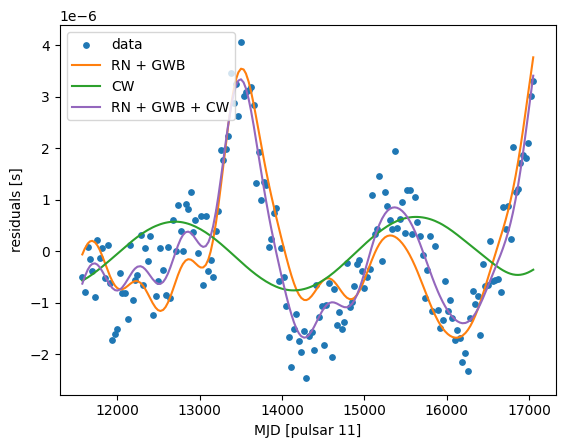

In [2]:
# plot data and injected signals
psr_ndx = 10
plt.scatter(m.MJDs[psr_ndx], m.Rs[psr_ndx] @ residuals[psr_ndx], color='C0', s=15, label='data')
if m.model_gwb or m.model_rn:
    rn_gwb_residuals_inj = m.Rs[psr_ndx] @ m.Fs[psr_ndx] @ m.a_inj.reshape((m.Np, m.Na))[psr_ndx]
    plt.plot(m.MJDs[psr_ndx], rn_gwb_residuals_inj, color='C1', label='RN + GWB')
if m.model_cw:
    cw_residuals_inj = m.Rs[psr_ndx] @ m.Fs[psr_ndx] @ m.get_CW_coefficients(m.x_inj[m.cw_psr_ndxs])[psr_ndx]
    plt.plot(m.MJDs[psr_ndx], cw_residuals_inj, color='C2', label='CW')
if (m.model_gwb or m.model_rn) and m.model_cw:
    plt.plot(m.MJDs[psr_ndx], rn_gwb_residuals_inj + cw_residuals_inj, color='C4', label='RN + GWB + CW')
plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.show()